<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/6_Segmentacion/Segmentacion.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Segmentación Semántica



Cuando hablamos de detección de objetos en la clase anterior, vimos que se usaban bounding boxes rectangulares para etiquetar y predecir objetos en las imágenes. En esta hablaremos de la segmentación semántica, que se enfoca en cómo dividir una imagen en regiones que pertenecen a diferentes clases semánticas. A diferencia de la detección de objetos, la segmentación semántica reconoce y comprende lo que hay en las imágenes a nivel de píxel: su etiquetado y predicción de regiones semánticas están a nivel de píxel. La siguiente figura muestra las etiquetas del perro, el gato y el fondo de la imagen en segmentación semántica. En comparación con la detección de objetos, los bordes a nivel de píxel etiquetados en la segmentación semántica son obviamente más detallados.

![Imgur](https://i.imgur.com/2f1Ic8D.png)


## Segmentación de imágenes y segmentación de instancias

También hay dos tareas importantes en el campo de la visión artificial que son similares a la segmentación semántica, a saber, la segmentación de imágenes y la segmentación de instancias. Los distinguiremos brevemente de la segmentación semántica de la siguiente manera.

* La **segmentación de imágenes** divide una imagen en varias regiones constituyentes. Los métodos para este tipo de problemas suelen hacer uso de la correlación entre píxeles de la imagen. No necesita información de etiqueta sobre los píxeles de la imagen durante el entrenamiento y no puede garantizar que las regiones segmentadas tengan la semántica que esperamos obtener durante la predicción. 

* La **segmentación de instancia**s también se denomina detección y segmentación simultáneas. Estudia cómo reconocer las regiones a nivel de píxeles de cada instancia de objeto en una imagen. A diferencia de la segmentación semántica, la segmentación de instancias necesita distinguir no solo la semántica, sino también diferentes instancias de objetos. Por ejemplo, si hay dos perros en la imagen, la segmentación de instancias debe distinguir a cuál de los dos perros pertenece un píxel.

![Imgur](https://i.imgur.com/47Gnqd9.png)




## El Dataset de segmentación semántica Pascal VOC2012

Uno de los conjuntos de datos de segmentación semántica más importantes es [Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).
A continuación, vamos a echar un vistazo a este conjunto de datos.

In [ ]:
%matplotlib inline
import os
import torch
import torchvision

The tar file of the dataset is about 2 GB,
so it may take a while to download the file.
The extracted dataset is located at `../data/VOCdevkit/VOC2012`.


In [ ]:
#@markdown Descarga de Datos
import collections
import hashlib
import inspect
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt


import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

def download(url, folder='data', sha1_hash=None):
    """Download a file to folder and return the local filepath.

    Defined in :numref:`sec_utils`"""
    if not url.startswith('http'):
        # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def extract(filename, folder=None):
    """Extract a zip/tar file into folder.

    Defined in :numref:`sec_utils`"""
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

def download_extract(name, folder=None):
    """Download and extract a zip/tar file.

    Defined in :numref:`sec_utils`"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir





DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['voc2012'] = (DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = download_extract('voc2012', 'VOCdevkit/VOC2012')

Después de ingresar a la carpeta `data/VOCdevkit/VOC2012`,
podemos ver los diferentes componentes del conjunto de datos.
La carpeta `ImageSets/Segmentation` contiene archivos de texto
que especifican ejemplos de entrenamiento y prueba, mientras que las carpetas `JPEGImages` y `SegmentationClass` almacenan la imagen de entrada y la etiqueta para cada ejemplo, respectivamente. 

**La etiqueta aquí también está en formato de imagen, con el mismo tamaño que su imagen de entrada etiquetada**. Además, **los píxeles con el mismo color en cualquier imagen de etiqueta pertenecen a la misma clase semántica**. Lo siguiente define la función `read_voc_images` para leer todas las imágenes y etiquetas de entrada en la memoria.


In [ ]:
def read_voc_images(voc_dir, n=-1,  is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        if i==n: break
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
        
    return features, labels

Dibujamos las primeras cinco imágenes de entrada y sus etiquetas. En las imágenes de las etiquetas, el blanco y el negro representan los bordes y el fondo, respectivamente, mientras que los demás colores corresponden a diferentes clases.

In [ ]:
#@markdown función show_images
from matplotlib import pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

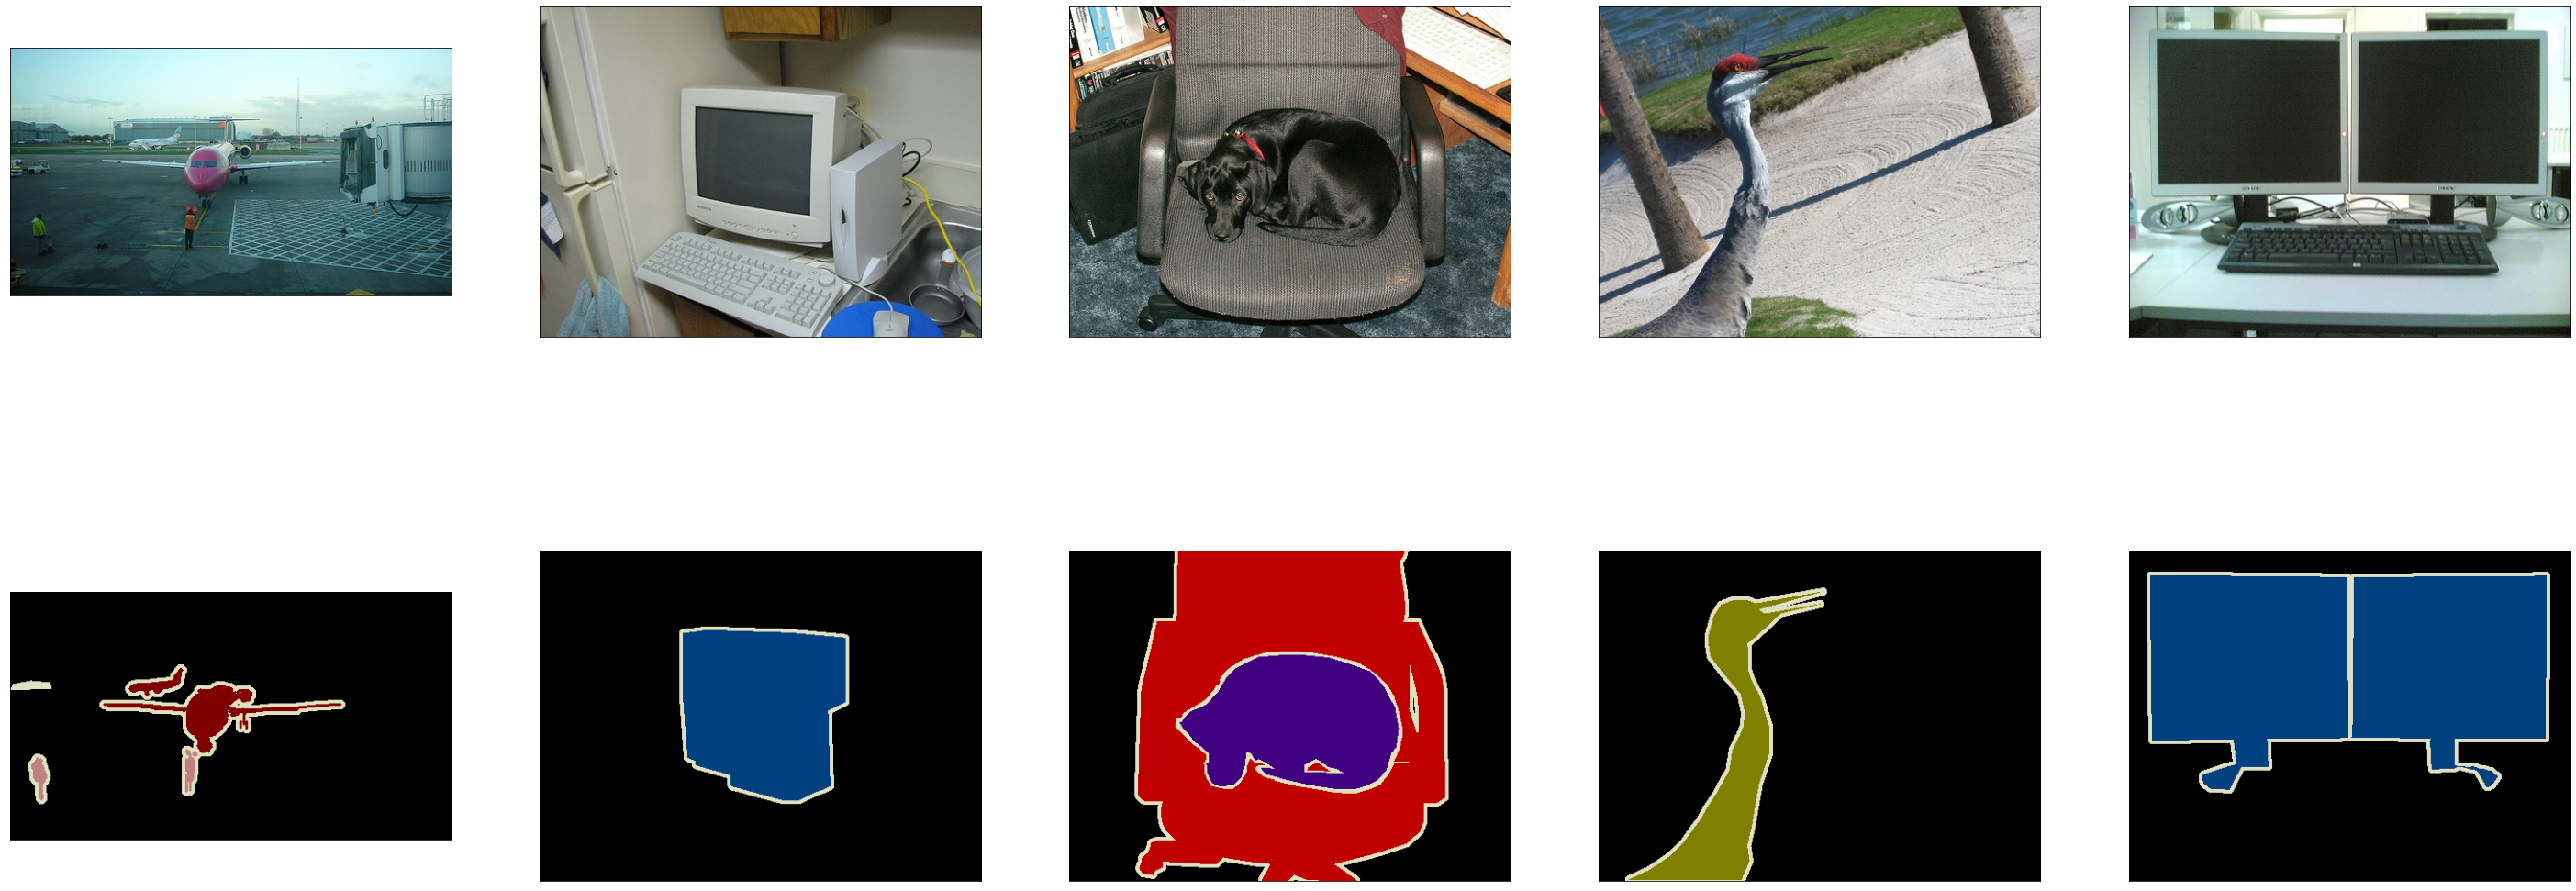

In [ ]:
n=5
train_features, train_labels = read_voc_images(voc_dir, n, True)
imgs = train_features + train_labels
imgs = [img.permute(1,2,0) for img in imgs]
show_images(imgs, 2, n, scale=10);

Next, we enumerate the RGB color values and class names for all the labels in this dataset.


In [ ]:

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]


VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

Con las dos constantes definidas anteriormente, podemos encontrar convenientemente el índice de clase para cada píxel en una etiqueta. Definimos la función `voc_colormap2label` para crear la asignación de los valores de color RGB anteriores a los índices de clase, y la función `voc_label_indices` para asignar cualquier valor RGB a sus índices de clase en este conjunto de datos Pascal VOC2012.


In [ ]:
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

Por ejemplo, en la primera imagen de ejemplo, el índice de clase para la parte delantera del avión es 1, mientras que el índice de fondo es 0.


In [ ]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]), 'aeroplane')

### Preprocesamiento de datos
En experimentos anteriores, hemos tenido que reescalar las imágenes para ajustarnos a la forma de entrada requerida por el modelo. Sin embargo, en la segmentación semántica, hacerlo requiere volver a escalar las clases de píxeles previstas para la forma original de la imagen de entrada. Tal cambio de escala puede ser inexacto, especialmente para regiones segmentadas con diferentes clases. Para evitar este problema, recortamos la imagen a una forma fija en lugar de cambiar la escala. Específicamente, usando el RandomCrop que vimos la primera vez que hicimos image augmentation, recortamos la misma área de la imagen de entrada y la etiqueta.


In [ ]:

def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

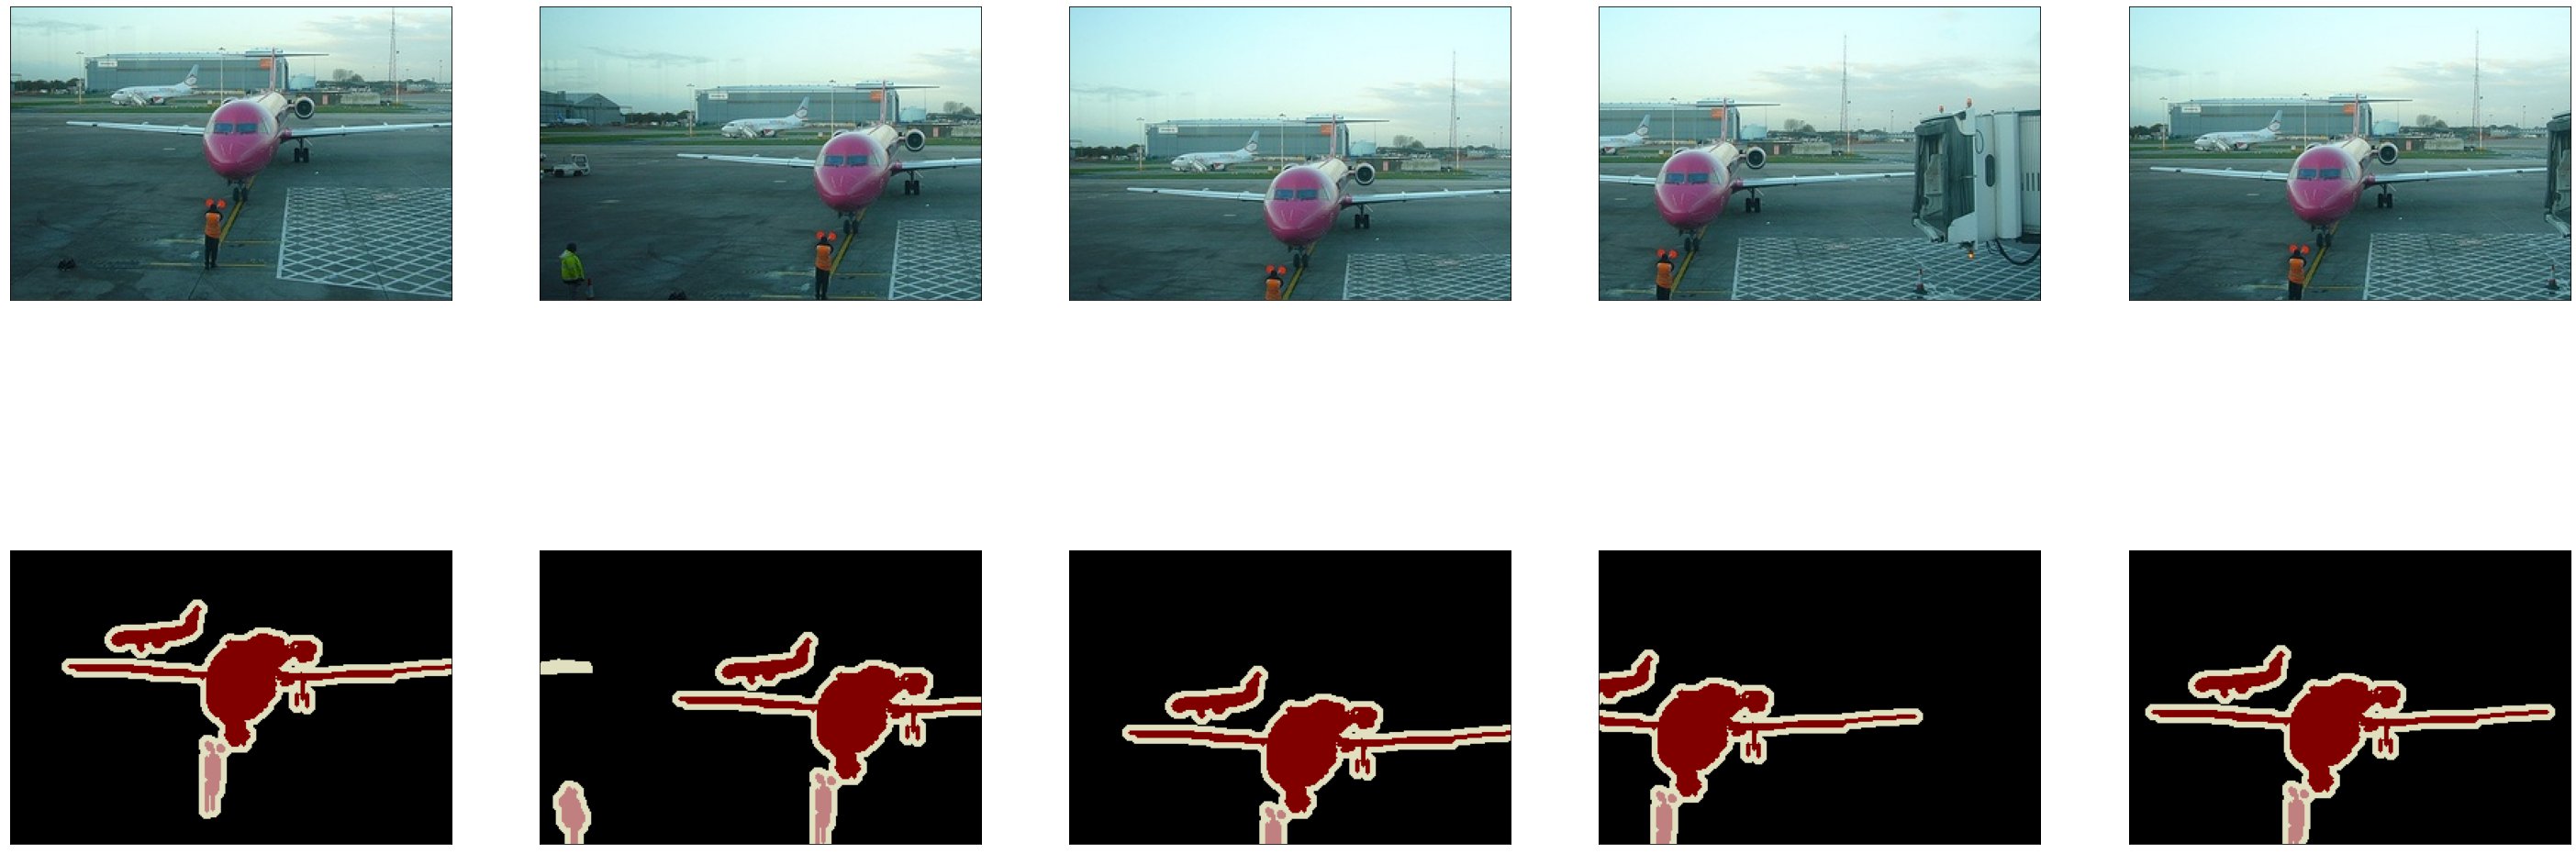

In [ ]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
show_images(imgs[::2] + imgs[1::2], 2, n, scale = 10);

### Dataset Personalizado de Segmentación Semántica

Definimos una clase de conjunto de datos de segmentación semántica personalizada `VOCSegDataset` heredando la clase `Dataset` proporcionada por las API de alto nivel. Al implementar la función `__getitem__`, podemos acceder arbitrariamente a la imagen de entrada indexada como `idx` en el conjunto de datos y al índice de clase de cada píxel en esta imagen. Dado que algunas imágenes en el conjunto de datos tienen un tamaño más pequeño que el tamaño de salida del recorte aleatorio, estos ejemplos se filtran mediante una función de "filtro" personalizada. Además, también definimos la función `normalize_image` para estandarizar los valores de los tres canales RGB de las imágenes de entrada.


In [ ]:

class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### Lectura del Dataset

Usamos la clase `VOCSegDataset` personalizada para crear instancias del conjunto de entrenamiento y el conjunto de prueba, respectivamente. Supongamos que especificamos que la forma de salida de las imágenes recortadas aleatoriamente es $320\times 480$. A continuación, podemos ver la cantidad de ejemplos que se retienen en el conjunto de entrenamiento y el conjunto de prueba.


In [ ]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


Al establecer el tamaño del lote en 64, definimos el iterador de datos para el conjunto de entrenamiento. Imprimamos la forma del primer minilote. A diferencia de la clasificación de imágenes o la detección de objetos, las etiquetas aquí son tensores tridimensionales.


In [ ]:
batch_size = 32
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=4)

test_iter = torch.utils.data.DataLoader(voc_test, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=4) 
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 320, 480])
torch.Size([32, 320, 480])


# Convolución transpuesta



Las capas de CNN que hemos visto hasta ahora, como las capas convolucionales  y las capas de pooling, normalmente reducen (reducen) las dimensiones espaciales (alto y ancho) de la entrada, o las mantienen sin cambios. En la segmentación semántica, que clasifica a nivel de píxel, será conveniente que las dimensiones espaciales de la entrada y la salida sean las mismas. Por ejemplo, la dimensión del canal en un píxel de salida puede contener los resultados de clasificación para el píxel de entrada en la misma posición espacial.

![Imgur](https://i.imgur.com/Xe6TLIJ.png)

Para lograr esto, especialmente después de que las capas CNN reducen las dimensiones espaciales, debemos usar otro tipo de capas CNN que sean capaces de aumentar las dimensiones espaciales de los mapas de características intermedias (**upsampling**). En esta sección, presentaremos la convolución transpuesta, para invertir las operaciones de downsampling por la convolución.


In [ ]:
import torch
from torch import nn

## Operación básica



Ignorando los canales por ahora, comencemos con
la operación básica de convolución transpuesta
con stride 1 y sin padding. Supongamos que
nos dan un tensor de entrada $n_h \times n_w$
y un kernel $k_h \times k_w$. Deslizar la ventana del kernel con un stride de 1 $n_w$ veces en cada fila y $n_h$ veces en cada columna, produce un total de $n_h n_w$ resultados intermedios.

![Imgur](https://i.imgur.com/LhlwnOr.png)

Cada resultado intermedio es un tensor $(n_h + k_h - 1) \times (n_w + k_w - 1)$ que se inicializan como ceros. Para calcular cada tensor intermedio, cada elemento en el tensor de entrada se multiplica por el kernel para que el tensor $k_h \times k_w$ resultante reemplace una porción en cada tensor intermedio. Tenga en cuenta que la posición de la porción reemplazada en cada tensor intermedio corresponde a la posición del elemento en el tensor de entrada utilizado para el cálculo. Al final, todos los resultados intermedios se suman para producir la salida.

Podemos implementar esta operación básica de convolución transpuesta `trans_conv` para una matriz de **entrada `X`** y una matriz de **kernel `K`**.


In [ ]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

A diferencia de la convolución normal que **reduce** los elementos de entrada a través del kernel, la convolución transpuesta **propaga** los elementos de entrada mediante el kernel, produciendo así **una salida mayor que la entrada**. Podemos construir el tensor de entrada X y el tensor kernel K de la figura para validar la salida de la implementación anterior de la operación de convolución transpuesta bidimensional básica.


In [ ]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

Alternatively,
when the input `X` and kernel `K` are both
four-dimensional tensors,
we can [**use high-level APIs to obtain the same results**].


In [ ]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

## Padding, Strides y Multiples Canales

A diferencia de la convolución regular donde se le aplica el padding a la entrada, en la convolución transpuesta se le aplica a la salida. Por ejemplo, al especificar el padding a ambos lados de la altura y el ancho como 1, la primera y la última fila y columna se eliminarán de la salida de convolución transpuesta.


In [ ]:

tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

Esto puede parecer contraintuitivo... ¿Por qué el padding (relleno en inglés) eliminaría dimensiones en vez de agregarlas? La respuesta viene del uso que se les da a estas convoluciones transpuestas. PyTorch (así como el resto de los frameworks de Deep Learning) sabe que la única razón por la que usarías una de estas convoluciones transpuestas, es para anular la reducción de dimensionalidad introducida por convoluciones regulares previas en la red. Por lo tanto, el padding de las convoluciones transpuestas está diseñado para **hacer lo contrario de lo que hace el padding en las convoluciones regulares**. De esta manera, sabemos que para contrarrestar los efectos de una convolución regular con padding 2, simplemente debemos agregar una convolución transpuesta con padding 2.

Siguiendo con la lógica anterior, el stride en la convolución transpuesta se especifica para saltearno píxeles en los resultados intermedios, no en la entrada. 

Usando los mismos tensores de entrada y kernel de la figura anterior, cambiar el stride de 1 a 2 aumenta tanto la altura como el ancho de los tensores intermedios, de ahí el tensor de salida de la figura siguiente

![Imgur](https://i.imgur.com/RrST4jp.png)

El siguiente fragmento de código puede validar la salida de la convolución transpuesta para un stride de 2.


In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

Para múltiples canales de entrada y salida, la convolución transpuesta funciona de la misma manera que la convolución normal. Suponga que la entrada tiene canales $c_i$ y que la convolución transpuesta asigna un  kernel $k_h\times k_w$ a cada canal de entrada. Cuando se especifican múltiples canales de salida, tendremos un kernel $c_i\times k_h\times k_w$ para cada canal de salida.


Como en todo, si alimentamos $\mathsf{X}$ en una capa convolucional $f$ para generar $\mathsf{Y}=f(\mathsf{X})$ y creamos una capa convolucional transpuesta $g$ con los mismos hiperparámetros que $f$ excepto que el número de canales de salida es el número de canales en $\mathsf{X}$, entonces $g(Y)$ tendrá la misma forma que $\mathsf{X}$. Esto se puede ilustrar en el siguiente ejemplo.




In [ ]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

## Conexión con las Matrices Transpuestas

La convolución transpuesta lleva el nombre de la matriz transpuesta. Para explicar por qué, primero veamos cómo implementar convoluciones usando multiplicaciones de matrices. En el siguiente ejemplo, definimos una entrada `X` de $3\times 3$ y un kernel de convolución `K` de $2\times 2$, y luego usamos la función `corr2d` para calcular la salida de convolución `Y`.


In [ ]:
#@markdown Función corr2d
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = reduce_sum((X[i: i + h, j: j + w] * K))
    return Y

In [ ]:
X = torch.arange(16.0).reshape(4, 4)
K = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
Y = corr2d(X, K)
Y

tensor([[303., 348.],
        [483., 528.]])

A continuación, reescribimos el kernel de convolución `K` como una matriz de pesos rala `W` que contiene muchos ceros. La forma de la matriz de peso es ($4$, $16$), donde los elementos distintos de cero provienen del kernel de convolución `K`.

![Imgur](https://i.imgur.com/kFH4lop.png)

Luego, concatenamos la entrada `X` fila por fila para obtener un vector de longitud 16. Luego, la multiplicación de la matriz de `W` y la vectorizada `X` da un vector de longitud 4. Después de remodelarlo, podemos obtener el mismo resultado `Y ` de la operación de convolución original anterior: acabamos de implementar convoluciones usando multiplicaciones de matrices.

In [ ]:
def kernel2matrix(K):
    k, W = torch.zeros(11), torch.zeros((4, 16))
    k[:3], k[4:7], k[8:11]= K[0, :], K[1, :], K[2, :]
    W[0, :11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
    return W

W = kernel2matrix(K)
print(W)
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)
#torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0.],
        [0., 0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9.]])


tensor([[True, True],
        [True, True]])

Del mismo modo, podemos implementar convoluciones transpuestas usando multiplicaciones de matrices. En el siguiente ejemplo, tomamos la salida `Y` de $2 \times 2$ de la convolución regular anterior como entrada a la convolución transpuesta. Para implementar esta operación multiplicando matrices, solo necesitamos transponer la matriz de pesos `W` con la nueva forma $(16, 4)$.

![Imgur](https://i.imgur.com/LxUw9xW.png)


In [ ]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(4, 4)

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

## Convolución Transpuesta vs Deconvolución

La capa convolucional transpuesta también se conoce (erróneamente) como la **capa deconvolucional**. 

Una capa deconvolucional invierte el funcionamiento de una capa convolucional estándar, es decir, si la salida generada a través de una capa convolucional estándar se deconvoluciona, **se recupera la entrada original**. La capa convolucional transpuesta es similar a la capa deconvolucional en el sentido de que la dimensión espacial generada por ambas es la misma. **La convolución transpuesta no invierte la convolución estándar por valores, sino solo por dimensiones**.

![Imgur](https://i.imgur.com/yonq54d.png)

# Fully Convolutional Networks


Como se discutió anteriormente, la segmentación semántica clasifica las imágenes a nivel de píxeles. Una **red totalmente convolucional (Fully Convolutional Network - FCN)** utiliza una red neuronal convolucional para transformar los píxeles de la imagen en clases de píxeles. A diferencia de las CNN que usamos anteriormente para la clasificación de imágenes o la detección de objetos, una red totalmente convolucional transforma la altura y el ancho de los mapas de activación intermedios de vuelta a los de la imagen de entrada: esto se logra mediante la capa convolucional transpuesta presentada en la sección anterior. Como resultado, **la salida de clasificación y la imagen de entrada tienen una correspondencia uno a uno en el nivel de píxel**: la dimensión del canal en cualquier píxel de salida contiene los resultados de clasificación para el píxel de entrada en la misma posición espacial.


In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

## El Modelo

Aquí describimos el diseño básico del modelo de red totalmente convolucional. Como se muestra en la figura, este modelo primero usa una CNN para extraer las características de la imagen, luego transforma el número de canales en el número de clases a través de una capa convolucional y finalmente transforma la altura y el ancho de los mapas de características en los de la imagen de entrada a través de la convolución transpuesta. Como resultado, la salida del modelo tiene la misma altura y anchura que la imagen de entrada, donde el canal de salida contiene las clases predichas para el píxel de entrada en la misma posición espacial.

![Imgur](https://i.imgur.com/b0TGWK2.png)

A continuación, usamos un modelo ResNet-18 preentrenado en el conjunto de datos de ImageNet para extraer las características de la imagen y denotar la instancia del modelo como `pretrained_net`. Las últimas capas de este modelo incluyen una capa de average pooling global y una capa densas: estas no son necesarias en la red totalmente convolucional.


In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

A continuación, creamos la instancia de red totalmente convolucional `net`. Copia todas las capas previamente entrenadas en ResNet-18, excepto la capa de averge pooling global final y la capa densa que están más cerca de la salida.


In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

Dada una entrada con una altura y un ancho de 320 y 480 respectivamente, la propagación directa de `net` reduce la altura y el ancho de entrada a 1/32 del original, es decir, 10 y 15.


In [ ]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

A continuación, usamos una capa convolucional $1\times 1$ para transformar la cantidad de canales de salida en la cantidad de clases (21) del conjunto de datos Pascal VOC2012.

In [ ]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))


Finalmente, necesitamos **aumentar la altura y el ancho de los mapas de características 32 veces** para volver a cambiarlos a la altura y el ancho de la imagen de entrada.

Recuerde cómo calcular la forma de salida de una capa convolucional:
$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

Si cambiáramos todas las capas convolucionales por una sola, podríamos decir que esa capa tendría un kernel de $64 \times 64$, un stride de $32$ y un padding de $16$, ya que:

$$(320-64+16\times2+32)/32=10$$ $$(480-64+16\times2+32)/32=15$$

En general, podemos ver que para stride $s$, padding $s/2$ (asumiendo que $s/2$ es un número entero), y la altura y el ancho del kernel $2s$,
la convolución transpuesta aumentará la altura y el ancho de la entrada $s$ veces. 




In [ ]:
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

## Inicializar las capas convolucionales transpuestas

Ya sabemos que las capas convolucionales transpuestas pueden aumentar la altura y el ancho de los mapas de características. En el procesamiento de imágenes, es posible que necesitemos escalar una imagen, es decir, hacemos ***upsampling***. La **interpolación bilineal** es una de las técnicas de upsampling más utilizadas. También se usa a menudo para inicializar capas convolucionales transpuestas.

Para explicar la interpolación bilineal, digamos que dada una imagen de entrada, queremos calcular cada píxel de la imagen de salida muestreada. Para calcular el píxel de la imagen de salida en la coordenada $(x, y)$, primero asigne $(x, y)$ a la coordenada $(x', y')$ en la imagen de entrada, por ejemplo, según la relación entre el tamaño de entrada y el tamaño de salida. Tenga en cuenta que $x'$ y $y'$ mapeados son números reales. Luego, busque los cuatro píxeles más cercanos a la coordenada $(x', y')$ en la imagen de entrada. Finalmente, el píxel de la imagen de salida en la coordenada $(x, y)$ se calcula en base a estos cuatro píxeles más cercanos en la imagen de entrada y su distancia relativa desde $(x', y')$.

![Imgur](https://i.imgur.com/IelcFLk.png)

El upsampling de la interpolación bilineal se puede implementar mediante la capa convolucional transpuesta con el kernel construido por la siguiente función `bilinear_kernel`. Debido a las limitaciones de espacio, solo proporcionamos la implementación de la función `bilinear_kernel` a continuación sin discusiones sobre el diseño de su algoritmo.


In [ ]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

Experimentemos con el upsampling de la interpolación bilineal que se implementa mediante una capa convolucional transpuesta. Construimos una capa convolucional transpuesta que duplica la altura y el ancho, e inicializamos su kernel con la función `bilinear_kernel`.


In [ ]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

Leemos la imagen `X` y asignamos la salida del upsampling a `Y`. Para imprimir la imagen, necesitamos ajustar la posición de la dimensión del canal.

In [ ]:
from PIL import Image
!wget https://i.imgur.com/qCm1mDw.jpg -O 'catdog.jpg'
img = torchvision.transforms.ToTensor()(Image.open('catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

--2022-10-03 18:03:55--  https://i.imgur.com/qCm1mDw.jpg
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30849 (30K) [image/jpeg]
Saving to: ‘catdog.jpg’

catdog.jpg          100%[===================>]  30.13K  --.-KB/s    in 0s      

2022-10-03 18:03:55 (130 MB/s) - ‘catdog.jpg’ saved [30849/30849]



Como podemos ver, la capa convolucional transpuesta aumenta tanto el alto como el ancho de la imagen por un factor de dos. Excepto por las diferentes escalas en coordenadas, la imagen ampliada por interpolación bilineal y la imagen original tienen el mismo aspecto.

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


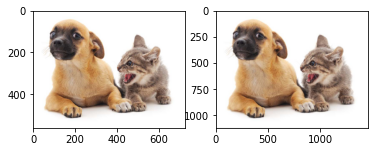

In [ ]:
import matplotlib.pyplot as plt
print('input image shape:', img.permute(1, 2, 0).shape)
print('output image shape:', out_img.shape)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img.permute(1, 2, 0))
axarr[1].imshow(out_img)


En una red totalmente convolucional, inicializamos la capa convolucional transpuesta con upsampling de interpolación bilineal. Para la capa convolucional $1\times 1$, usamos la inicialización de Xavier.


In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## Entrenamiento


Ahora podemos entrenar nuestra red totalmente convolucional. La función de pérdida y el cálculo del accuracy aquí no son esencialmente diferentes de los de la clasificación de imágenes de capítulos anteriores. 

Debido a que usamos los canales de la salida de la capa convolucional transpuesta para predecir la clase de cada píxel, la dimensión del canal se especifica en el cálculo de la función de pérdida. Además, la precisión se calcula en función de la corrección de la clase predicha para todos los píxeles.


In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)
    
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
num_epochs, lr, wd, device = 10, 0.003, 1e-3, torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
model = net.to(device)

for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    Acc_N = 0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        l = loss(model(X),y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(model(X), y)
        Acc_N += y.numel()
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        TestN += y.numel()
        TestAcc += accuracy(model(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/Acc_N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 0.456505          , train accuracy  0.864974, test accuracy 0.840893
epoch 2, loss 0.445273          , train accuracy  0.867511, test accuracy 0.839667
epoch 3, loss 0.449955          , train accuracy  0.866399, test accuracy 0.840589
epoch 4, loss 0.435816          , train accuracy  0.869913, test accuracy 0.838571
epoch 5, loss 0.433340          , train accuracy  0.871423, test accuracy 0.842586
epoch 6, loss 0.432258          , train accuracy  0.870202, test accuracy 0.841482
epoch 7, loss 0.424187          , train accuracy  0.872110, test accuracy 0.841817
epoch 8, loss 0.419150          , train accuracy  0.873319, test accuracy 0.843731
epoch 9, loss 0.418631          , train accuracy  0.874062, test accuracy 0.844661
epoch 10, loss 0.415501          , train accuracy  0.874501, test accuracy 0.843628


## Predicción

Al predecir, necesitamos estandarizar la imagen de entrada en cada canal y transformar la imagen al formato de entrada de cuatro dimensiones requerido por la CNN.


In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(device)).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

Para visualizar la clase prevista de cada píxel, mapeamos la clase prevista de nuevo a su color de etiqueta en el conjunto de datos.

In [ ]:
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=device)
    X = pred.long()
    return colormap[X, :]

Las imágenes en el conjunto de datos de prueba varían en tamaño y forma. Dado que el modelo utiliza una capa convolucional transpuesta con un paso de 32, cuando la altura o el ancho de una imagen de entrada es indivisible por 32, la altura o el ancho de salida de la capa convolucional transpuesta se desviará de la forma de la imagen de entrada. Para solucionar este problema, podemos recortar varias áreas rectangulares con una altura y un ancho que sean múltiplos enteros de 32 en la imagen y realizar la propagación hacia adelante en los píxeles de estas áreas por separado. Tenga en cuenta que la unión de estas áreas rectangulares debe cubrir completamente la imagen de entrada. Cuando un píxel está cubierto por múltiples áreas rectangulares, el promedio de las salidas de convolución transpuestas en áreas separadas para este mismo píxel se puede ingresar a la operación softmax para predecir la clase.


Para simplificar, solo leemos algunas imágenes de prueba más grandes y recortamos un área de $ 320 \times 480 $ para la predicción a partir de la esquina superior izquierda de una imagen. Para estas imágenes de prueba, imprimimos sus áreas recortadas, los resultados de la predicción y la verdad sobre el terreno fila por fila.


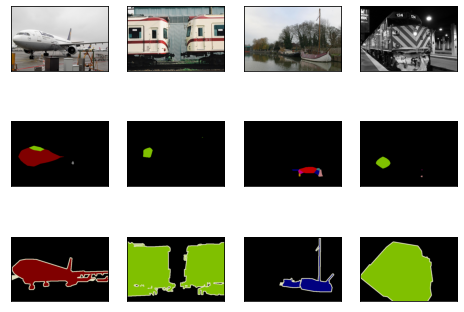

In [ ]:
n, imgs = 4, []
test_images, test_labels = read_voc_images(voc_dir,n,False)


for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);